In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models
import pandas as pd
import random

nltk.download('stopwords')
nltk.download('punkt')

df = pd.read_csv('./mining/reddit_clean.csv')
df['text'] = df['title'].fillna('') + ' ' + df['selftext'].fillna('')


/usr/lib/python3/dist-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alireza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alireza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = df[df['created_utc'] >= 1677654056]


In [3]:
import emoji
import re

def clean_text(text):
    if not isinstance(text, str): return " "
    text = text.lower()
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

df['clean_text'] = df['text'].apply(clean_text)
df['clean_title'] = df['title'].apply(clean_text)
df['clean_selftext'] = df['selftext'].apply(clean_text)

In [24]:
!pip3 install wordcloud

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.8/222.8 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for wordcloud: filename=wordcloud-1.9.2-cp39-cp39-macosx_10_9_universal2.whl size=220329 sha256=77e09195bb5fc4b09c165b3510052415c46dc69d04b9abdd274974a9f418a421
  Stored in directory: /Users/alirezaarvandi/Library/Caches/pip/wheels/fd/79/b1/1e0a49160de8dfb17c54736cc73759e1d26f9343b61c0d5441
Successfully built wordcloud

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alireza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/alireza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


('fire', 'wildfir', 'smoke', 'lake', 'post', 'question', 'would', 'like', 'see', 'get') (0.4746537891084042, 0.25636216940848483, 0.1771508643696955, 0.16026473345057374, 0.13508904735297403, 0.12710651273666193, 0.12649247161233024, 0.12587843048799854, 0.12065908093117908, 0.11636079306085718)


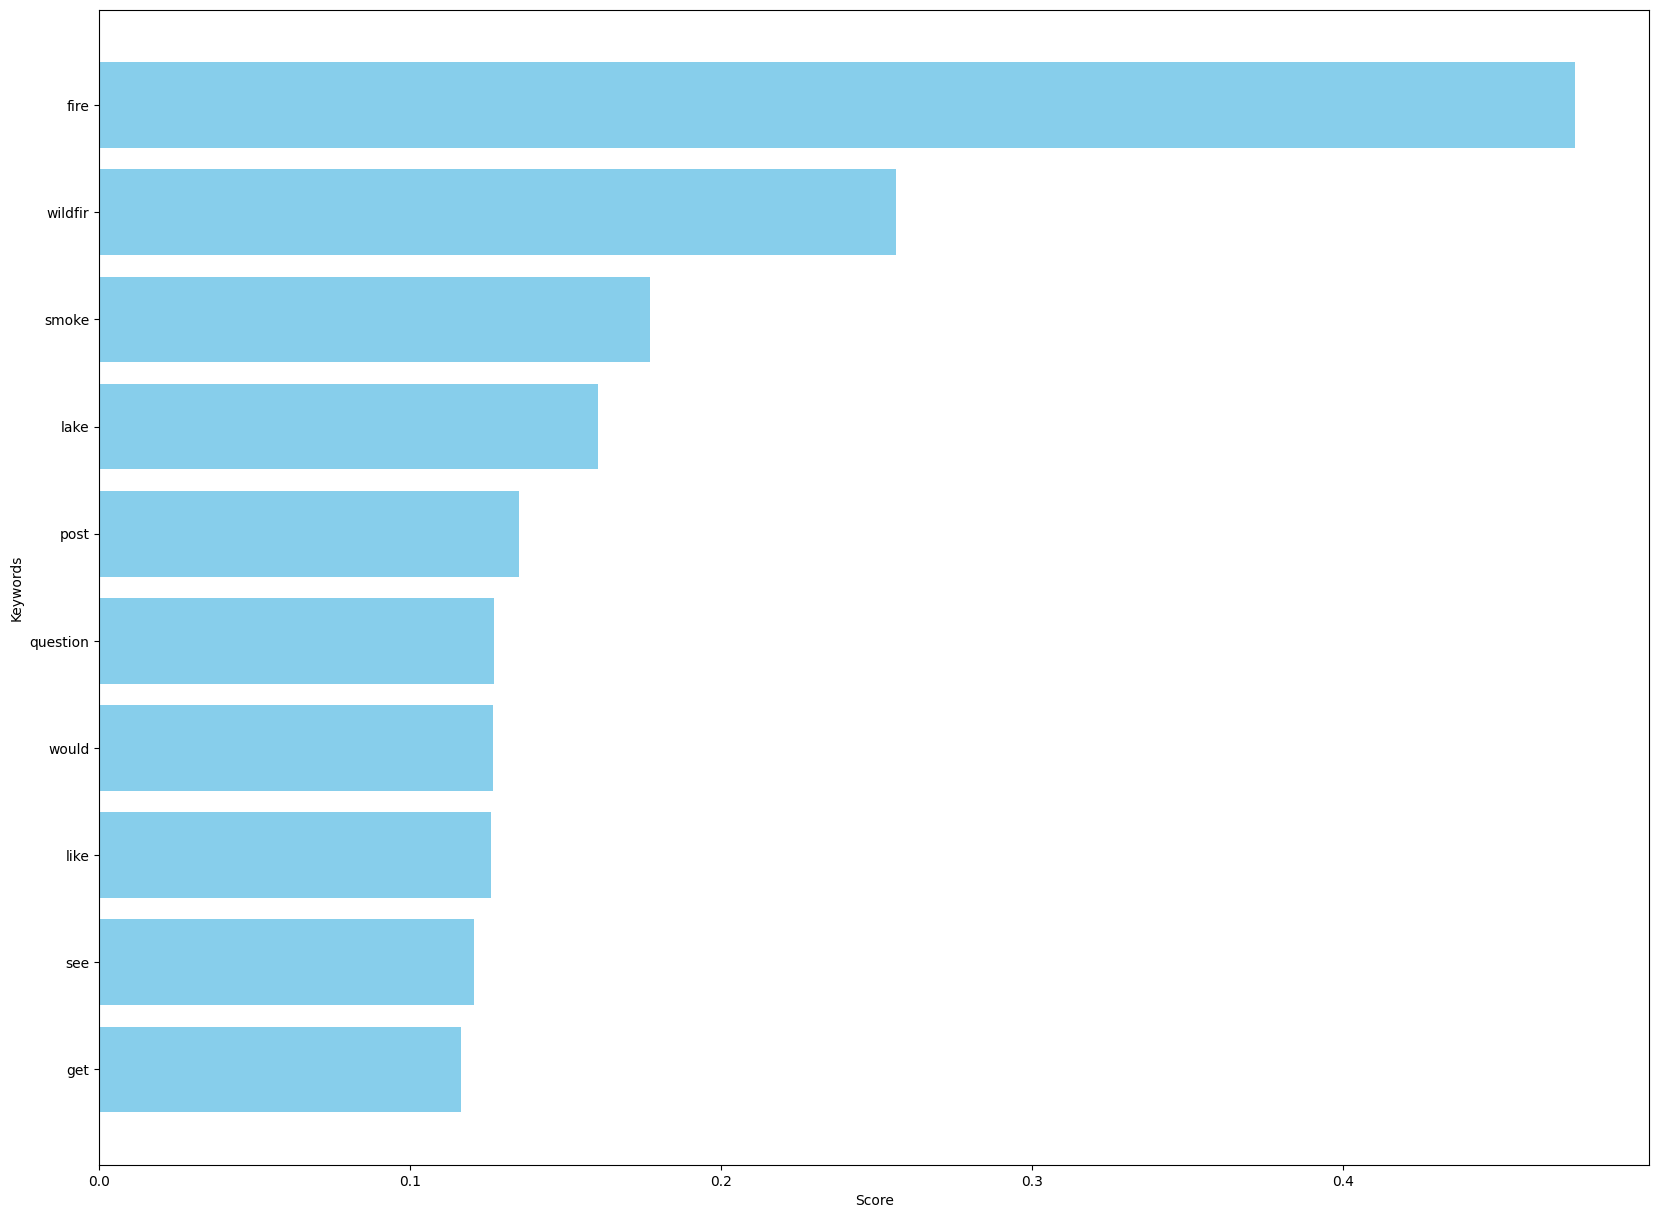

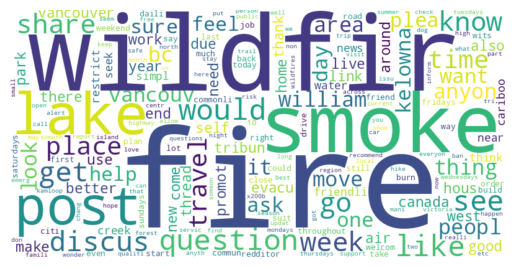

In [4]:
# Keyword tf idf based on clean_title

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk

# Download resources
nltk.download('stopwords')
nltk.download('wordnet')

new_df = df.copy()
new_df = new_df[new_df['clean_text'].notna()]

# Text Preprocessing
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]
    return ' '.join(lemmatized_tokens)

combined_title = ' '.join(df['clean_text'])
preprocessed_combined_title = preprocess(combined_title)

# Compute TF-IDF
vectorizer = TfidfVectorizer()
tf_matrix = vectorizer.fit_transform([preprocessed_combined_title])
feature_names = vectorizer.get_feature_names_out()

# Extract and sort term frequencies
tf_array = tf_matrix.toarray()
tf_scores = [(feature_names[i], tf_array[0, i]) for i in range(len(feature_names))]
tf_scores.sort(key=lambda x: x[1], reverse=True)

# Get the most frequently used keywords
most_frequent_keywords = [(word, score) for word, score in tf_scores]

keywords, frequencies = zip(*most_frequent_keywords[:10])  # Taking top 10 for visualization
print(keywords, frequencies)

import matplotlib.pyplot as plt

# Create the bar chart
plt.barh(keywords, frequencies, color='skyblue')
plt.xlabel('Score')
plt.ylabel('Keywords')
plt.gca().invert_yaxis()  # Invert y-axis to show the keyword with the highest frequency at the top
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 20})
fig = plt.gcf()
width = 20
aspect_ratio = fig.get_figheight() / fig.get_figwidth()
fig.set_size_inches(width, width * aspect_ratio)
plt.show()

from wordcloud import WordCloud

# Create a dictionary of keywords and their frequencies
keyword_dict = dict(most_frequent_keywords)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_dict)

# Display the word cloud using Matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')


plt.show()

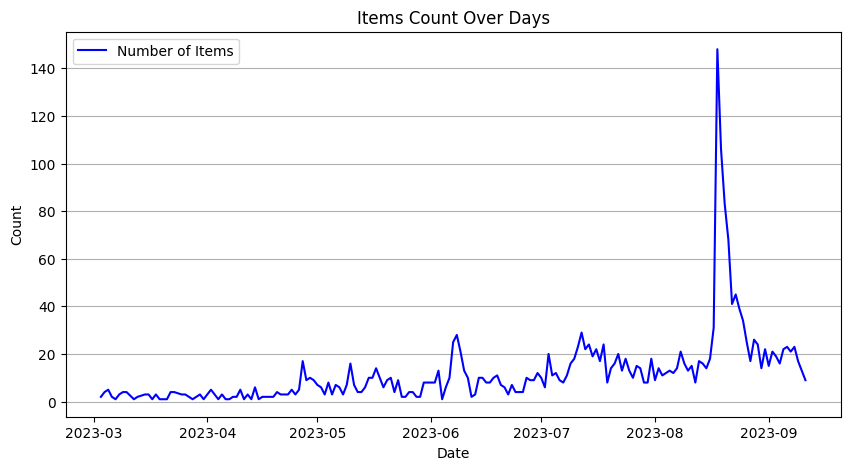

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have already loaded the dataframe 'df' and filtered it as in your code

df['time'] = pd.to_datetime(df['created_utc'], unit='s')

daily_counts = df.groupby(df['time'].dt.date).size()

plt.figure(figsize=(10, 5))
plt.plot(daily_counts.index, daily_counts, label='Number of Items', color='blue')

plt.title('Items Count Over Days')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(axis='y')
plt.show()

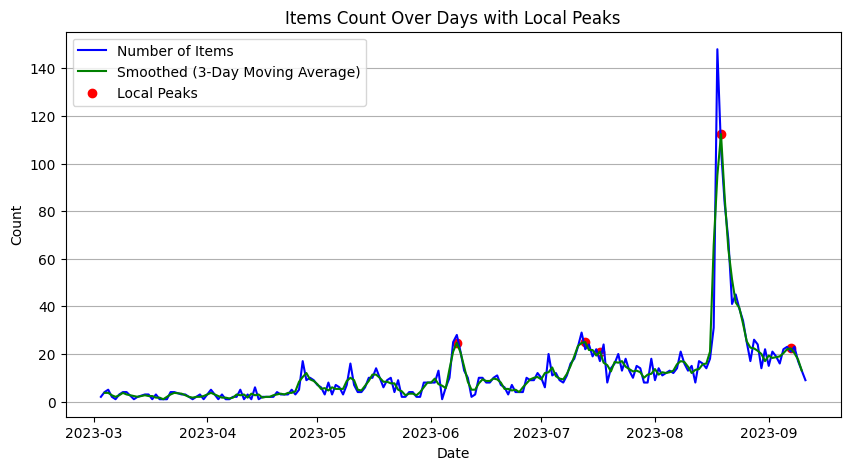

Dates of Local Peaks: Index([2023-06-08, 2023-07-13, 2023-07-17, 2023-08-19, 2023-09-07], dtype='object', name='time')


In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

df['time'] = pd.to_datetime(df['created_utc'], unit='s')

daily_counts = df.groupby(df['time'].dt.date).size()

window_size = 3
smoothed_counts = daily_counts.rolling(window=window_size, center=True).mean()

threshold = 20

peaks, _ = find_peaks(smoothed_counts, height=threshold)

plt.figure(figsize=(10, 5))
plt.plot(daily_counts.index, daily_counts, label='Number of Items', color='blue')
plt.plot(daily_counts.index, smoothed_counts, label=f'Smoothed ({window_size}-Day Moving Average)', color='green')
plt.scatter(daily_counts.index[peaks], smoothed_counts.iloc[peaks], color='red', marker='o', label='Local Peaks')

plt.title('Items Count Over Days with Local Peaks')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(axis='y')

plt.show()

peak_dates = daily_counts.index[peaks]
print("Dates of Local Peaks:", peak_dates)

#average of all datapoints for calculating a good threshold

In [46]:
for peak_date in peak_dates:
    print(peak_date)
    start_date = peak_date - pd.Timedelta(days=3)
    end_date = peak_date
    selected_rows = df[(df['time'].dt.date >= start_date) & (df['time'].dt.date <= end_date)]
    print(f"Peak at {peak_date} with {len(selected_rows)} items:")
    topic_mining(selected_rows)

2023-06-08
Peak at 2023-06-08 with 69 items:
Topic 1: lake, tribune, wildfire, williams, fire, due, wildfires, ridge, tumbler, smoke
Examples:
live from our district’s hecm course today when this part came up in the slideshow like 5 guys audibly gasped and one very seriously said “okay but what if i just swallow it” lol
williams lake fire department open house a success - mycariboonow.com  
cannabis retailer fire & flower files for court protection from creditors under ccaa  
canada minister bill blair: there are currently 414 wildfires burning across the country, with 239 of them classified as out of control. more than 20,000 people have been evacuated and hundreds of homes have been destroyed  
out-of-control wildfire on lower mainland sees massive growth  

Topic 2: fire, canada, wildfire, tax, smoke, lvt, land, vancouver, would, harrison
Examples:
vancouver fire rescue services on twitter - numerous set fires in the downtown eastside yesterday, including several garbage cans and du